In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = ct.NOT_DELIVERYING_PENALTY 

## System initializer

In [3]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
print("States space dimension: ",toy_system.states_dim)
print("Actions space dimension: ",toy_system.actions_dim)
a_s_dim = toy_system.states_dim * toy_system.actions_dim
print("States-Actions space dimension: ",a_s_dim)

States space dimension:  36864
Actions space dimension:  36
States-Actions space dimension:  1327104


In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print("Tank max loads: ",system.tank_max_loads())
print("Tank dayly rates: ",system.tank_rates())
print("Truck max loads: ",system.truck_max_loads())
print("Graph: \n",system.graph)
print("Weights: \n", system.weights)

Tank max loads:  [100.0, 200.0, 100.0, 800.0, 200.0]
Tank dayly rates:  [16.5, 4.0, 10.500000000000002, 84.00000000000001, 34.0]
Truck max loads:  [70.0, 130.0]
Graph: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
Weights: 
 [[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

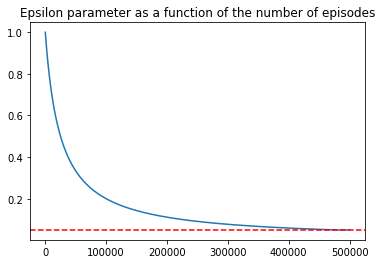

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 5*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3 #3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 225
add_noise = True

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system(noise = add_noise, seed = seed)
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

if train_epsilon == False and retrain == False:
     pass
else: # Create directories for the simulations' outputs

    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

    if not os.path.exists(simulation_directory):
        os.makedirs(simulation_directory)
        os.makedirs(simulation_directory + '/Q-dictionaries')
        os.makedirs(simulation_directory + '/discrewards')
        os.makedirs(simulation_directory + '/vis')

#     else:
#         raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")


#     ut.save_obj(toy_system, simulation_directory+"/system-sim"+"{}".format(simulation_id)) 

#     # Output headers to file
#     with open(rewards_file,'w') as f:
#          np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print("Training finished. Total episodes: {}. Elapsed time: {} minutes.".format(n_episodes,round(end_time/60., round_time)))        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
# if train_epsilon == False and retrain == False:
#     pass
# elif train_epsilon == True and retrain == False:
#     episodic_train_Q_epsilon()
# elif train_epsilon == False and retrain == True:
#     Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode_retrain))
#     episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
# else:
#     raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    

Episode: 100. Elapsed time  0.09  minuts. epsilon 0.9961 Discounted reward:  -18.78805480007713
Episode: 200. Elapsed time  0.2  minuts. epsilon 0.9921 Discounted reward:  -19.386735114486374
Episode: 300. Elapsed time  0.34  minuts. epsilon 0.9882 Discounted reward:  -18.47482278680857
Episode: 400. Elapsed time  0.49  minuts. epsilon 0.9843 Discounted reward:  -14.181792579263801
Episode: 500. Elapsed time  0.65  minuts. epsilon 0.9804 Discounted reward:  -20.994681301439037
Episode: 600. Elapsed time  0.83  minuts. epsilon 0.9766 Discounted reward:  -22.1633585949151
Episode: 700. Elapsed time  1.02  minuts. epsilon 0.9728 Discounted reward:  -22.66494772423078
Episode: 800. Elapsed time  1.23  minuts. epsilon 0.969 Discounted reward:  -14.608927878718223
Episode: 900. Elapsed time  1.44  minuts. epsilon 0.9653 Discounted reward:  -15.419672666826886
Episode: 1000. Elapsed time  1.66  minuts. epsilon 0.9616 Discounted reward:  -21.6381287313702
Episode: 1100. Elapsed time  1.9  minu

Episode: 8500. Elapsed time  34.17  minuts. epsilon 0.7463 Discounted reward:  -13.374108716944514
Episode: 8600. Elapsed time  34.73  minuts. epsilon 0.7441 Discounted reward:  -10.74511167972081
Episode: 8700. Elapsed time  35.3  minuts. epsilon 0.7419 Discounted reward:  -13.566031740686551
Episode: 8800. Elapsed time  35.86  minuts. epsilon 0.7397 Discounted reward:  -15.104372314175585
Episode: 8900. Elapsed time  36.44  minuts. epsilon 0.7375 Discounted reward:  -12.016538777342955
Episode: 9000. Elapsed time  37.02  minuts. epsilon 0.7353 Discounted reward:  -16.168981286061058
Episode: 9100. Elapsed time  37.59  minuts. epsilon 0.7332 Discounted reward:  -12.79430518281243
Episode: 9200. Elapsed time  38.16  minuts. epsilon 0.731 Discounted reward:  -17.076205559342746
Episode: 9300. Elapsed time  38.73  minuts. epsilon 0.7289 Discounted reward:  -8.657353021281157
Episode: 9400. Elapsed time  39.31  minuts. epsilon 0.7268 Discounted reward:  -8.90272092691398
Episode: 9500. El

Episode: 16800. Elapsed time  88.95  minuts. epsilon 0.5981 Discounted reward:  -7.84485664919399
Episode: 16900. Elapsed time  89.68  minuts. epsilon 0.5967 Discounted reward:  -10.752014047754997
Episode: 17000. Elapsed time  90.36  minuts. epsilon 0.5953 Discounted reward:  -13.130188848519442
Episode: 17100. Elapsed time  91.09  minuts. epsilon 0.5938 Discounted reward:  -11.98015660106446
Episode: 17200. Elapsed time  91.81  minuts. epsilon 0.5924 Discounted reward:  -14.658775289786973
Episode: 17300. Elapsed time  92.54  minuts. epsilon 0.591 Discounted reward:  -12.875075294555502
Episode: 17400. Elapsed time  93.29  minuts. epsilon 0.5896 Discounted reward:  -10.649296237967805
Episode: 17500. Elapsed time  94.02  minuts. epsilon 0.5882 Discounted reward:  -10.288401514621441
Episode: 17600. Elapsed time  94.75  minuts. epsilon 0.5869 Discounted reward:  -4.811136595473231
Episode: 17700. Elapsed time  95.47  minuts. epsilon 0.5855 Discounted reward:  -9.272970463526777
Episod

Episode: 25000. Elapsed time  151.73  minuts. epsilon 0.5 Discounted reward:  -8.369685755561193
Episode: 25100. Elapsed time  152.5  minuts. epsilon 0.499 Discounted reward:  -16.057550490789076
Episode: 25200. Elapsed time  153.28  minuts. epsilon 0.498 Discounted reward:  -5.73315153615709
Episode: 25300. Elapsed time  154.07  minuts. epsilon 0.497 Discounted reward:  -6.2857860701676325
Episode: 25400. Elapsed time  154.87  minuts. epsilon 0.496 Discounted reward:  -5.744503376657616
Episode: 25500. Elapsed time  155.66  minuts. epsilon 0.4951 Discounted reward:  -8.781904029940788
Episode: 25600. Elapsed time  156.48  minuts. epsilon 0.4941 Discounted reward:  -14.334877441198332
Episode: 25700. Elapsed time  157.28  minuts. epsilon 0.4931 Discounted reward:  -3.4395194665803492
Episode: 25800. Elapsed time  158.1  minuts. epsilon 0.4921 Discounted reward:  -6.573918990154563
Episode: 25900. Elapsed time  158.9  minuts. epsilon 0.4912 Discounted reward:  -10.210361664804944
Episod

Episode: 33200. Elapsed time  220.16  minuts. epsilon 0.4296 Discounted reward:  -5.13010008072419
Episode: 33300. Elapsed time  221.01  minuts. epsilon 0.4288 Discounted reward:  -3.6252843895078257
Episode: 33400. Elapsed time  221.86  minuts. epsilon 0.4281 Discounted reward:  -3.3335874560495613
Episode: 33500. Elapsed time  222.72  minuts. epsilon 0.4274 Discounted reward:  -7.093448310325783
Episode: 33600. Elapsed time  223.59  minuts. epsilon 0.4266 Discounted reward:  -7.857905163120082
Episode: 33700. Elapsed time  224.44  minuts. epsilon 0.4259 Discounted reward:  -4.67323656883181
Episode: 33800. Elapsed time  225.3  minuts. epsilon 0.4252 Discounted reward:  -8.10996354161927
Episode: 33900. Elapsed time  226.17  minuts. epsilon 0.4245 Discounted reward:  -7.437570818236863
Episode: 34000. Elapsed time  227.02  minuts. epsilon 0.4237 Discounted reward:  -5.321976225839579
Episode: 34100. Elapsed time  227.89  minuts. epsilon 0.423 Discounted reward:  -4.7063195247018115
Ep

Episode: 41400. Elapsed time  292.16  minuts. epsilon 0.3765 Discounted reward:  -5.838583426192613
Episode: 41500. Elapsed time  293.08  minuts. epsilon 0.3759 Discounted reward:  -4.417387193651345
Episode: 41600. Elapsed time  293.98  minuts. epsilon 0.3754 Discounted reward:  -4.264442710481081
Episode: 41700. Elapsed time  294.9  minuts. epsilon 0.3748 Discounted reward:  -5.3761377085182565
Episode: 41800. Elapsed time  295.76  minuts. epsilon 0.3743 Discounted reward:  -4.523795698824896
Episode: 41900. Elapsed time  296.66  minuts. epsilon 0.3737 Discounted reward:  -3.0129883669491893
Episode: 42000. Elapsed time  297.57  minuts. epsilon 0.3731 Discounted reward:  -1.461246361173646
Episode: 42100. Elapsed time  298.46  minuts. epsilon 0.3726 Discounted reward:  -5.384878002496743
Episode: 42200. Elapsed time  299.35  minuts. epsilon 0.372 Discounted reward:  -8.473633906211543
Episode: 42300. Elapsed time  300.23  minuts. epsilon 0.3715 Discounted reward:  -6.984808800955935


Episode: 49600. Elapsed time  367.0  minuts. epsilon 0.3351 Discounted reward:  -1.1000849515213103
Episode: 49700. Elapsed time  367.94  minuts. epsilon 0.3347 Discounted reward:  -6.48618360456354
Episode: 49800. Elapsed time  368.86  minuts. epsilon 0.3342 Discounted reward:  -4.826576933329754
Episode: 49900. Elapsed time  369.79  minuts. epsilon 0.3338 Discounted reward:  -5.246442609680669
Episode: 50000. Elapsed time  370.71  minuts. epsilon 0.3333 Discounted reward:  -9.741667447175645
Episode: 50100. Elapsed time  371.64  minuts. epsilon 0.3329 Discounted reward:  -3.1776511524917574
Episode: 50200. Elapsed time  372.57  minuts. epsilon 0.3325 Discounted reward:  -3.8959501672119643
Episode: 50300. Elapsed time  373.5  minuts. epsilon 0.332 Discounted reward:  -9.442756121474257
Episode: 50400. Elapsed time  374.42  minuts. epsilon 0.3316 Discounted reward:  -8.85557030665902
Episode: 50500. Elapsed time  375.35  minuts. epsilon 0.3311 Discounted reward:  -9.196155583569057
Ep

Episode: 57800. Elapsed time  445.4  minuts. epsilon 0.3019 Discounted reward:  -3.551735060860991
Episode: 57900. Elapsed time  446.47  minuts. epsilon 0.3016 Discounted reward:  -3.4465474447108035
Episode: 58000. Elapsed time  447.5  minuts. epsilon 0.3012 Discounted reward:  -6.181094945909919
Episode: 58100. Elapsed time  448.54  minuts. epsilon 0.3008 Discounted reward:  -4.4126905216716885
Episode: 58200. Elapsed time  449.57  minuts. epsilon 0.3005 Discounted reward:  -7.773005585889505
Episode: 58300. Elapsed time  450.51  minuts. epsilon 0.3001 Discounted reward:  -1.1762318474508522
Episode: 58400. Elapsed time  451.49  minuts. epsilon 0.2998 Discounted reward:  -3.696854862701821
Episode: 58500. Elapsed time  452.46  minuts. epsilon 0.2994 Discounted reward:  -7.908274768268209
Episode: 58600. Elapsed time  453.45  minuts. epsilon 0.299 Discounted reward:  -2.9122188153250317
Episode: 58700. Elapsed time  454.43  minuts. epsilon 0.2987 Discounted reward:  -5.598586169056491

Episode: 66000. Elapsed time  525.3  minuts. epsilon 0.2747 Discounted reward:  -1.8781903040800358
Episode: 66100. Elapsed time  526.27  minuts. epsilon 0.2744 Discounted reward:  -5.586692774908435
Episode: 66200. Elapsed time  527.24  minuts. epsilon 0.2741 Discounted reward:  -3.6793136803083835
Episode: 66300. Elapsed time  528.21  minuts. epsilon 0.2738 Discounted reward:  -2.1294412772495557
Episode: 66400. Elapsed time  529.17  minuts. epsilon 0.2735 Discounted reward:  -2.5702879519745676
Episode: 66500. Elapsed time  530.14  minuts. epsilon 0.2732 Discounted reward:  -2.735045232188592
Episode: 66600. Elapsed time  531.11  minuts. epsilon 0.2729 Discounted reward:  -3.934145511677589
Episode: 66700. Elapsed time  532.08  minuts. epsilon 0.2726 Discounted reward:  -1.7034975562440666
Episode: 66800. Elapsed time  533.05  minuts. epsilon 0.2723 Discounted reward:  -3.1861930742460087
Episode: 66900. Elapsed time  534.03  minuts. epsilon 0.272 Discounted reward:  -5.445374415493

Episode: 74200. Elapsed time  605.55  minuts. epsilon 0.252 Discounted reward:  -3.697929064957483
Episode: 74300. Elapsed time  606.53  minuts. epsilon 0.2518 Discounted reward:  -7.80608450113768
Episode: 74400. Elapsed time  607.52  minuts. epsilon 0.2515 Discounted reward:  -5.787412088236739
Episode: 74500. Elapsed time  608.5  minuts. epsilon 0.2513 Discounted reward:  -3.6032414646546074
Episode: 74600. Elapsed time  609.5  minuts. epsilon 0.251 Discounted reward:  -2.7040158284525373
Episode: 74700. Elapsed time  610.48  minuts. epsilon 0.2508 Discounted reward:  -1.708208382484926
Episode: 74800. Elapsed time  611.49  minuts. epsilon 0.2505 Discounted reward:  -2.5876661665618235
Episode: 74900. Elapsed time  612.45  minuts. epsilon 0.2503 Discounted reward:  -2.5678263598543865
Episode: 75000. Elapsed time  613.42  minuts. epsilon 0.25 Discounted reward:  -4.504310383209713
Episode: 75100. Elapsed time  614.4  minuts. epsilon 0.2498 Discounted reward:  -2.104274655514146
Epis

Episode: 82400. Elapsed time  686.86  minuts. epsilon 0.2328 Discounted reward:  -1.1447708659642846
Episode: 82500. Elapsed time  687.86  minuts. epsilon 0.2326 Discounted reward:  -2.4094074659760816
Episode: 82600. Elapsed time  688.87  minuts. epsilon 0.2323 Discounted reward:  -2.3266330469521543
Episode: 82700. Elapsed time  689.86  minuts. epsilon 0.2321 Discounted reward:  -1.7174427558188232
Episode: 82800. Elapsed time  690.84  minuts. epsilon 0.2319 Discounted reward:  -3.600520079920141
Episode: 82900. Elapsed time  691.86  minuts. epsilon 0.2317 Discounted reward:  -1.6962176931550146
Episode: 83000. Elapsed time  692.86  minuts. epsilon 0.2315 Discounted reward:  -1.1568913410702286
Episode: 83100. Elapsed time  693.89  minuts. epsilon 0.2313 Discounted reward:  -5.746277582696386
Episode: 83200. Elapsed time  694.87  minuts. epsilon 0.2311 Discounted reward:  -6.437100011778324
Episode: 83300. Elapsed time  695.88  minuts. epsilon 0.2308 Discounted reward:  -6.3829659454

Episode: 90600. Elapsed time  769.16  minuts. epsilon 0.2163 Discounted reward:  -5.560586620714293
Episode: 90700. Elapsed time  770.16  minuts. epsilon 0.2161 Discounted reward:  -3.8515410781794466
Episode: 90800. Elapsed time  771.17  minuts. epsilon 0.2159 Discounted reward:  -1.3210224179274914
Episode: 90900. Elapsed time  772.19  minuts. epsilon 0.2157 Discounted reward:  -1.4531166036578678
Episode: 91000. Elapsed time  773.21  minuts. epsilon 0.2155 Discounted reward:  -2.1588313924754576
Episode: 91100. Elapsed time  774.22  minuts. epsilon 0.2153 Discounted reward:  -4.0787863711327095
Episode: 91200. Elapsed time  775.23  minuts. epsilon 0.2151 Discounted reward:  -1.6212693717714501
Episode: 91300. Elapsed time  776.24  minuts. epsilon 0.215 Discounted reward:  -4.4860493828244365
Episode: 91400. Elapsed time  777.27  minuts. epsilon 0.2148 Discounted reward:  -0.7588007701412605
Episode: 91500. Elapsed time  778.28  minuts. epsilon 0.2146 Discounted reward:  -2.534537256

Episode: 98800. Elapsed time  852.66  minuts. epsilon 0.2019 Discounted reward:  -4.817581890124877
Episode: 98900. Elapsed time  853.69  minuts. epsilon 0.2018 Discounted reward:  -1.9165982496362215
Episode: 99000. Elapsed time  854.71  minuts. epsilon 0.2016 Discounted reward:  -1.9275804319834895
Episode: 99100. Elapsed time  855.75  minuts. epsilon 0.2015 Discounted reward:  -1.8584255028639947
Episode: 99200. Elapsed time  856.79  minuts. epsilon 0.2013 Discounted reward:  -1.7282909242816868
Episode: 99300. Elapsed time  857.82  minuts. epsilon 0.2011 Discounted reward:  -3.0639323545876964
Episode: 99400. Elapsed time  858.83  minuts. epsilon 0.201 Discounted reward:  -1.1114358775002946
Episode: 99500. Elapsed time  859.84  minuts. epsilon 0.2008 Discounted reward:  -3.0665481068580727
Episode: 99600. Elapsed time  860.87  minuts. epsilon 0.2006 Discounted reward:  -4.89546541137411
Episode: 99700. Elapsed time  861.91  minuts. epsilon 0.2005 Discounted reward:  -1.01449149305

Episode: 106900. Elapsed time  935.69  minuts. epsilon 0.1895 Discounted reward:  -4.726204139510376
Episode: 107000. Elapsed time  936.74  minuts. epsilon 0.1894 Discounted reward:  -2.723450904105737
Episode: 107100. Elapsed time  937.76  minuts. epsilon 0.1893 Discounted reward:  -6.272254555431839
Episode: 107200. Elapsed time  938.79  minuts. epsilon 0.1891 Discounted reward:  -1.3264908600340035
Episode: 107300. Elapsed time  939.82  minuts. epsilon 0.189 Discounted reward:  -0.29740142715894713
Episode: 107400. Elapsed time  940.86  minuts. epsilon 0.1888 Discounted reward:  -1.4331458086432065
Episode: 107500. Elapsed time  941.87  minuts. epsilon 0.1887 Discounted reward:  -1.0751789888824044
Episode: 107600. Elapsed time  942.9  minuts. epsilon 0.1885 Discounted reward:  -0.3065062820327353
Episode: 107700. Elapsed time  943.96  minuts. epsilon 0.1884 Discounted reward:  -1.4826341713378333
Episode: 107800. Elapsed time  945.01  minuts. epsilon 0.1883 Discounted reward:  -1.3

Episode: 115000. Elapsed time  1019.6  minuts. epsilon 0.1786 Discounted reward:  -0.7598127979223721
Episode: 115100. Elapsed time  1020.63  minuts. epsilon 0.1784 Discounted reward:  -1.486564094822013
Episode: 115200. Elapsed time  1021.67  minuts. epsilon 0.1783 Discounted reward:  -1.9602023503846389
Episode: 115300. Elapsed time  1022.71  minuts. epsilon 0.1782 Discounted reward:  -2.896113903087358
Episode: 115400. Elapsed time  1023.71  minuts. epsilon 0.1781 Discounted reward:  -5.752877516254817
Episode: 115500. Elapsed time  1024.71  minuts. epsilon 0.1779 Discounted reward:  -1.7387644392157915
Episode: 115600. Elapsed time  1025.74  minuts. epsilon 0.1778 Discounted reward:  -1.8051811195391207
Episode: 115700. Elapsed time  1026.75  minuts. epsilon 0.1777 Discounted reward:  -2.366529507618311
Episode: 115800. Elapsed time  1027.74  minuts. epsilon 0.1776 Discounted reward:  -3.9430333830586544
Episode: 115900. Elapsed time  1028.95  minuts. epsilon 0.1774 Discounted rewa

Episode: 123000. Elapsed time  1102.87  minuts. epsilon 0.1689 Discounted reward:  -3.3559782823207427
Episode: 123100. Elapsed time  1103.94  minuts. epsilon 0.1688 Discounted reward:  -0.8254560433157704
Episode: 123200. Elapsed time  1105.0  minuts. epsilon 0.1687 Discounted reward:  -0.3888321404779684
Episode: 123300. Elapsed time  1106.05  minuts. epsilon 0.1686 Discounted reward:  -1.229668753378486
Episode: 123400. Elapsed time  1107.1  minuts. epsilon 0.1685 Discounted reward:  -1.2153998867243905
Episode: 123500. Elapsed time  1108.14  minuts. epsilon 0.1684 Discounted reward:  -3.0049226763029147
Episode: 123600. Elapsed time  1109.18  minuts. epsilon 0.1682 Discounted reward:  -2.3533048680119535
Episode: 123700. Elapsed time  1110.22  minuts. epsilon 0.1681 Discounted reward:  -0.698022660924848
Episode: 123800. Elapsed time  1111.26  minuts. epsilon 0.168 Discounted reward:  -3.025750296645161
Episode: 123900. Elapsed time  1112.31  minuts. epsilon 0.1679 Discounted rewar

Episode: 131000. Elapsed time  1186.6  minuts. epsilon 0.1603 Discounted reward:  -2.338846747379362
Episode: 131100. Elapsed time  1187.66  minuts. epsilon 0.1602 Discounted reward:  -2.085907826732389
Episode: 131200. Elapsed time  1188.69  minuts. epsilon 0.1601 Discounted reward:  -3.3586335662101257
Episode: 131300. Elapsed time  1189.73  minuts. epsilon 0.1599 Discounted reward:  -2.817965467569866
Episode: 131400. Elapsed time  1190.77  minuts. epsilon 0.1598 Discounted reward:  -1.8833787352505467
Episode: 131500. Elapsed time  1191.82  minuts. epsilon 0.1597 Discounted reward:  -1.8242052316295858
Episode: 131600. Elapsed time  1192.88  minuts. epsilon 0.1596 Discounted reward:  -5.382286364579776
Episode: 131700. Elapsed time  1193.89  minuts. epsilon 0.1595 Discounted reward:  -3.0445443322227863
Episode: 131800. Elapsed time  1194.92  minuts. epsilon 0.1594 Discounted reward:  -0.861431203694193
Episode: 131900. Elapsed time  1195.97  minuts. epsilon 0.1593 Discounted rewar

Episode: 139000. Elapsed time  1270.46  minuts. epsilon 0.1524 Discounted reward:  -1.2010333886159483
Episode: 139100. Elapsed time  1271.52  minuts. epsilon 0.1523 Discounted reward:  -0.9086100312647319
Episode: 139200. Elapsed time  1272.58  minuts. epsilon 0.1523 Discounted reward:  -3.6988698934850044
Episode: 139300. Elapsed time  1273.64  minuts. epsilon 0.1522 Discounted reward:  -4.729599326592645
Episode: 139400. Elapsed time  1274.67  minuts. epsilon 0.1521 Discounted reward:  -3.5661562315493227
Episode: 139500. Elapsed time  1275.71  minuts. epsilon 0.152 Discounted reward:  -2.3684614509058566
Episode: 139600. Elapsed time  1276.78  minuts. epsilon 0.1519 Discounted reward:  -1.6867678595594229
Episode: 139700. Elapsed time  1277.83  minuts. epsilon 0.1518 Discounted reward:  -3.5305676871081615
Episode: 139800. Elapsed time  1278.85  minuts. epsilon 0.1517 Discounted reward:  -3.7245660835000063
Episode: 139900. Elapsed time  1279.89  minuts. epsilon 0.1516 Discounted r

Episode: 147000. Elapsed time  1354.45  minuts. epsilon 0.1453 Discounted reward:  -0.5832462049856185
Episode: 147100. Elapsed time  1355.5  minuts. epsilon 0.1453 Discounted reward:  -0.4013022717051027
Episode: 147200. Elapsed time  1356.55  minuts. epsilon 0.1452 Discounted reward:  -1.8441030501428564
Episode: 147300. Elapsed time  1357.59  minuts. epsilon 0.1451 Discounted reward:  -2.6213369981551673
Episode: 147400. Elapsed time  1358.64  minuts. epsilon 0.145 Discounted reward:  -0.8563449653472848
Episode: 147500. Elapsed time  1359.68  minuts. epsilon 0.1449 Discounted reward:  -0.5213158636532313
Episode: 147600. Elapsed time  1360.74  minuts. epsilon 0.1448 Discounted reward:  -0.42580613265280326
Episode: 147700. Elapsed time  1361.79  minuts. epsilon 0.1448 Discounted reward:  -2.958034024666914
Episode: 147800. Elapsed time  1362.82  minuts. epsilon 0.1447 Discounted reward:  -0.4358099549677029
Episode: 147900. Elapsed time  1363.84  minuts. epsilon 0.1446 Discounted r

Episode: 155000. Elapsed time  1436.68  minuts. epsilon 0.1389 Discounted reward:  -0.16199369854796544
Episode: 155100. Elapsed time  1437.62  minuts. epsilon 0.1388 Discounted reward:  -1.953682578037238
Episode: 155200. Elapsed time  1438.55  minuts. epsilon 0.1387 Discounted reward:  -3.686973032742768
Episode: 155300. Elapsed time  1439.49  minuts. epsilon 0.1387 Discounted reward:  -2.811536751346953
Episode: 155400. Elapsed time  1440.42  minuts. epsilon 0.1386 Discounted reward:  -0.5622862434368678
Episode: 155500. Elapsed time  1441.37  minuts. epsilon 0.1385 Discounted reward:  -0.38183710131287846
Episode: 155600. Elapsed time  1442.33  minuts. epsilon 0.1384 Discounted reward:  -1.6891350517282677
Episode: 155700. Elapsed time  1443.27  minuts. epsilon 0.1384 Discounted reward:  -0.4944849621841223
Episode: 155800. Elapsed time  1444.21  minuts. epsilon 0.1383 Discounted reward:  -1.0117136380490066
Episode: 155900. Elapsed time  1445.14  minuts. epsilon 0.1382 Discounted 

Episode: 163000. Elapsed time  1525.94  minuts. epsilon 0.133 Discounted reward:  -2.4318711022191875
Episode: 163100. Elapsed time  1528.12  minuts. epsilon 0.1329 Discounted reward:  -2.6851907854638695
Episode: 163200. Elapsed time  1530.32  minuts. epsilon 0.1328 Discounted reward:  -2.965609254966101
Episode: 163300. Elapsed time  1532.51  minuts. epsilon 0.1328 Discounted reward:  -0.39299018847535294
Episode: 163400. Elapsed time  1534.67  minuts. epsilon 0.1327 Discounted reward:  -1.6361171948247302
Episode: 163500. Elapsed time  1536.84  minuts. epsilon 0.1326 Discounted reward:  -0.25591511761377517
Episode: 163600. Elapsed time  1538.84  minuts. epsilon 0.1326 Discounted reward:  -3.9986266823928456
Episode: 163700. Elapsed time  1540.89  minuts. epsilon 0.1325 Discounted reward:  -3.4202581807037933
Episode: 163800. Elapsed time  1542.98  minuts. epsilon 0.1324 Discounted reward:  -0.2703638533206426
Episode: 163900. Elapsed time  1545.03  minuts. epsilon 0.1323 Discounted

Episode: 171000. Elapsed time  1640.12  minuts. epsilon 0.1276 Discounted reward:  -1.2934447359989072
Episode: 171100. Elapsed time  1641.19  minuts. epsilon 0.1275 Discounted reward:  -4.14090713320133
Episode: 171200. Elapsed time  1642.24  minuts. epsilon 0.1274 Discounted reward:  -1.354633108584391
Episode: 171300. Elapsed time  1643.31  minuts. epsilon 0.1274 Discounted reward:  -6.2485045623063735
Episode: 171400. Elapsed time  1644.38  minuts. epsilon 0.1273 Discounted reward:  -0.8445250435359228
Episode: 171500. Elapsed time  1645.44  minuts. epsilon 0.1272 Discounted reward:  -1.8296192217272587
Episode: 171600. Elapsed time  1646.5  minuts. epsilon 0.1272 Discounted reward:  -3.399911307576123
Episode: 171700. Elapsed time  1647.55  minuts. epsilon 0.1271 Discounted reward:  -1.5172435473193253
Episode: 171800. Elapsed time  1648.58  minuts. epsilon 0.127 Discounted reward:  -2.6417165228588306
Episode: 171900. Elapsed time  1649.64  minuts. epsilon 0.127 Discounted reward

Episode: 179000. Elapsed time  1726.51  minuts. epsilon 0.1225 Discounted reward:  -1.6658417942680503
Episode: 179100. Elapsed time  1727.61  minuts. epsilon 0.1225 Discounted reward:  -2.712693875376889
Episode: 179200. Elapsed time  1728.71  minuts. epsilon 0.1224 Discounted reward:  -1.51535101271871
Episode: 179300. Elapsed time  1729.8  minuts. epsilon 0.1224 Discounted reward:  -3.404869105022105
Episode: 179400. Elapsed time  1730.88  minuts. epsilon 0.1223 Discounted reward:  -1.2783089250542188
Episode: 179500. Elapsed time  1731.97  minuts. epsilon 0.1222 Discounted reward:  -2.5639330013851978
Episode: 179600. Elapsed time  1733.06  minuts. epsilon 0.1222 Discounted reward:  -0.009416501671644628
Episode: 179700. Elapsed time  1734.17  minuts. epsilon 0.1221 Discounted reward:  -1.5349619239449526
Episode: 179800. Elapsed time  1735.28  minuts. epsilon 0.1221 Discounted reward:  -3.134665637895738
Episode: 179900. Elapsed time  1736.41  minuts. epsilon 0.122 Discounted rewa

Episode: 187000. Elapsed time  1814.19  minuts. epsilon 0.1179 Discounted reward:  -0.7421614229823317
Episode: 187100. Elapsed time  1815.26  minuts. epsilon 0.1179 Discounted reward:  -1.0236112609265653
Episode: 187200. Elapsed time  1816.33  minuts. epsilon 0.1178 Discounted reward:  -0.08176066111944008
Episode: 187300. Elapsed time  1817.4  minuts. epsilon 0.1178 Discounted reward:  -2.66592650407752
Episode: 187400. Elapsed time  1818.46  minuts. epsilon 0.1177 Discounted reward:  -3.459284193904683
Episode: 187500. Elapsed time  1819.52  minuts. epsilon 0.1176 Discounted reward:  -2.12567342935142
Episode: 187600. Elapsed time  1820.56  minuts. epsilon 0.1176 Discounted reward:  -0.563848623198247
Episode: 187700. Elapsed time  1822.87  minuts. epsilon 0.1175 Discounted reward:  -2.0686705968277517
Episode: 187800. Elapsed time  1823.93  minuts. epsilon 0.1175 Discounted reward:  -2.52820904044526
Episode: 187900. Elapsed time  1824.96  minuts. epsilon 0.1174 Discounted reward:

Episode: 195000. Elapsed time  1919.38  minuts. epsilon 0.1136 Discounted reward:  -1.3405514802757332
Episode: 195100. Elapsed time  1920.49  minuts. epsilon 0.1136 Discounted reward:  -2.677068037967316
Episode: 195200. Elapsed time  1921.58  minuts. epsilon 0.1135 Discounted reward:  -2.059867063798846
Episode: 195300. Elapsed time  1922.67  minuts. epsilon 0.1135 Discounted reward:  -0.7750907771034719
Episode: 195400. Elapsed time  1923.78  minuts. epsilon 0.1134 Discounted reward:  -1.361015398299465
Episode: 195500. Elapsed time  1924.86  minuts. epsilon 0.1134 Discounted reward:  -0.939616588702712
Episode: 195600. Elapsed time  1925.94  minuts. epsilon 0.1133 Discounted reward:  -1.6112758116711245
Episode: 195700. Elapsed time  1927.04  minuts. epsilon 0.1133 Discounted reward:  -1.864129525819546
Episode: 195800. Elapsed time  1928.12  minuts. epsilon 0.1132 Discounted reward:  -0.12528286711450864
Episode: 195900. Elapsed time  1929.17  minuts. epsilon 0.1132 Discounted rew

Episode: 203000. Elapsed time  2010.24  minuts. epsilon 0.1096 Discounted reward:  -5.160847862769213
Episode: 203100. Elapsed time  2011.37  minuts. epsilon 0.1096 Discounted reward:  -1.0001710897719585
Episode: 203200. Elapsed time  2012.69  minuts. epsilon 0.1096 Discounted reward:  -3.1246649747899484
Episode: 203300. Elapsed time  2013.8  minuts. epsilon 0.1095 Discounted reward:  -1.5959668434351095
Episode: 203400. Elapsed time  2014.88  minuts. epsilon 0.1095 Discounted reward:  -2.074880549768282
Episode: 203500. Elapsed time  2016.14  minuts. epsilon 0.1094 Discounted reward:  -7.547383867368551
Episode: 203600. Elapsed time  2017.45  minuts. epsilon 0.1094 Discounted reward:  -6.139838219268095
Episode: 203700. Elapsed time  2018.57  minuts. epsilon 0.1093 Discounted reward:  -1.0581456918034036
Episode: 203800. Elapsed time  2019.68  minuts. epsilon 0.1093 Discounted reward:  -4.577327488971446
Episode: 203900. Elapsed time  2021.21  minuts. epsilon 0.1092 Discounted rewar

Episode: 211000. Elapsed time  2098.47  minuts. epsilon 0.1059 Discounted reward:  -0.013418664914627176
Episode: 211100. Elapsed time  2099.55  minuts. epsilon 0.1059 Discounted reward:  -1.016009742084085
Episode: 211200. Elapsed time  2100.61  minuts. epsilon 0.1058 Discounted reward:  -0.10438288669091914
Episode: 211300. Elapsed time  2101.68  minuts. epsilon 0.1058 Discounted reward:  -0.7713659122179856
Episode: 211400. Elapsed time  2102.76  minuts. epsilon 0.1058 Discounted reward:  -5.137281617402465
Episode: 211500. Elapsed time  2103.82  minuts. epsilon 0.1057 Discounted reward:  -2.245524282664704
Episode: 211600. Elapsed time  2104.89  minuts. epsilon 0.1057 Discounted reward:  -0.7675729690051004
Episode: 211700. Elapsed time  2105.96  minuts. epsilon 0.1056 Discounted reward:  -1.4438788808536085
Episode: 211800. Elapsed time  2107.03  minuts. epsilon 0.1056 Discounted reward:  -0.7121371271916249
Episode: 211900. Elapsed time  2108.09  minuts. epsilon 0.1055 Discounted

Episode: 219000. Elapsed time  2185.65  minuts. epsilon 0.1025 Discounted reward:  -2.451224530759845
Episode: 219100. Elapsed time  2186.74  minuts. epsilon 0.1024 Discounted reward:  -0.16497069183573926
Episode: 219200. Elapsed time  2187.81  minuts. epsilon 0.1024 Discounted reward:  -0.011999059064967506
Episode: 219300. Elapsed time  2188.87  minuts. epsilon 0.1023 Discounted reward:  -0.49852929692353015
Episode: 219400. Elapsed time  2189.95  minuts. epsilon 0.1023 Discounted reward:  -2.7858402822383184
Episode: 219500. Elapsed time  2191.17  minuts. epsilon 0.1022 Discounted reward:  -2.7754538911633
Episode: 219600. Elapsed time  2192.27  minuts. epsilon 0.1022 Discounted reward:  -1.4218611103721686
Episode: 219700. Elapsed time  2193.4  minuts. epsilon 0.1022 Discounted reward:  -0.567406745725392
Episode: 219800. Elapsed time  2194.5  minuts. epsilon 0.1021 Discounted reward:  -2.2595207927787118
Episode: 219900. Elapsed time  2195.59  minuts. epsilon 0.1021 Discounted re

Episode: 227000. Elapsed time  2274.3  minuts. epsilon 0.0992 Discounted reward:  -0.8249418898421099
Episode: 227100. Elapsed time  2275.4  minuts. epsilon 0.0992 Discounted reward:  -2.676320733805949
Episode: 227200. Elapsed time  2276.52  minuts. epsilon 0.0991 Discounted reward:  -0.23953270830653936
Episode: 227300. Elapsed time  2277.63  minuts. epsilon 0.0991 Discounted reward:  -0.3693778938179011
Episode: 227400. Elapsed time  2278.72  minuts. epsilon 0.099 Discounted reward:  -0.05593629642084309
Episode: 227500. Elapsed time  2279.84  minuts. epsilon 0.099 Discounted reward:  -0.8436713956546189
Episode: 227600. Elapsed time  2280.95  minuts. epsilon 0.099 Discounted reward:  -0.9535950087048417
Episode: 227700. Elapsed time  2282.06  minuts. epsilon 0.0989 Discounted reward:  -1.5499385210866794
Episode: 227800. Elapsed time  2283.15  minuts. epsilon 0.0989 Discounted reward:  -1.4266143103495295
Episode: 227900. Elapsed time  2284.27  minuts. epsilon 0.0989 Discounted rew

Episode: 235000. Elapsed time  2363.17  minuts. epsilon 0.0962 Discounted reward:  -0.36075334198365544
Episode: 235100. Elapsed time  2364.26  minuts. epsilon 0.0961 Discounted reward:  -1.0770108692672378
Episode: 235200. Elapsed time  2365.38  minuts. epsilon 0.0961 Discounted reward:  -0.01987369195666002
Episode: 235300. Elapsed time  2366.49  minuts. epsilon 0.096 Discounted reward:  -1.5849693317139506
Episode: 235400. Elapsed time  2367.6  minuts. epsilon 0.096 Discounted reward:  -1.734610474768825
Episode: 235500. Elapsed time  2368.71  minuts. epsilon 0.096 Discounted reward:  -1.3588640083527
Episode: 235600. Elapsed time  2369.83  minuts. epsilon 0.0959 Discounted reward:  -3.1997584336566933
Episode: 235700. Elapsed time  2370.94  minuts. epsilon 0.0959 Discounted reward:  -0.07427704864240484
Episode: 235800. Elapsed time  2372.04  minuts. epsilon 0.0959 Discounted reward:  -4.265274612063144
Episode: 235900. Elapsed time  2373.12  minuts. epsilon 0.0958 Discounted rewar

Episode: 243000. Elapsed time  2452.66  minuts. epsilon 0.0933 Discounted reward:  -1.7881728183946541
Episode: 243100. Elapsed time  2453.76  minuts. epsilon 0.0932 Discounted reward:  -0.9128649414445379
Episode: 243200. Elapsed time  2454.89  minuts. epsilon 0.0932 Discounted reward:  -0.9572034052398063
Episode: 243300. Elapsed time  2456.01  minuts. epsilon 0.0932 Discounted reward:  -1.7463441907540591
Episode: 243400. Elapsed time  2457.12  minuts. epsilon 0.0931 Discounted reward:  -1.6433621305361206
Episode: 243500. Elapsed time  2458.26  minuts. epsilon 0.0931 Discounted reward:  -0.8218328542038008
Episode: 243600. Elapsed time  2459.36  minuts. epsilon 0.0931 Discounted reward:  -5.179564506247666
Episode: 243700. Elapsed time  2460.47  minuts. epsilon 0.093 Discounted reward:  -2.417263226004641
Episode: 243800. Elapsed time  2461.6  minuts. epsilon 0.093 Discounted reward:  -1.3493002981538156
Episode: 243900. Elapsed time  2462.71  minuts. epsilon 0.093 Discounted rewar

Episode: 251000. Elapsed time  2542.25  minuts. epsilon 0.0906 Discounted reward:  -1.0484675950237146
Episode: 251100. Elapsed time  2543.36  minuts. epsilon 0.0905 Discounted reward:  -2.321020589281541
Episode: 251200. Elapsed time  2544.48  minuts. epsilon 0.0905 Discounted reward:  -1.9056192374785403
Episode: 251300. Elapsed time  2545.6  minuts. epsilon 0.0905 Discounted reward:  -0.10844619158263445
Episode: 251400. Elapsed time  2546.72  minuts. epsilon 0.0904 Discounted reward:  -0.3594686567684757
Episode: 251500. Elapsed time  2547.84  minuts. epsilon 0.0904 Discounted reward:  -0.6416864546615615
Episode: 251600. Elapsed time  2548.95  minuts. epsilon 0.0904 Discounted reward:  -0.40573139740323644
Episode: 251700. Elapsed time  2550.06  minuts. epsilon 0.0904 Discounted reward:  -2.149441010203525
Episode: 251800. Elapsed time  2551.19  minuts. epsilon 0.0903 Discounted reward:  -0.010662806482420097
Episode: 251900. Elapsed time  2552.31  minuts. epsilon 0.0903 Discounte

Episode: 259000. Elapsed time  2631.87  minuts. epsilon 0.088 Discounted reward:  -0.8133267191237312
Episode: 259100. Elapsed time  2632.99  minuts. epsilon 0.088 Discounted reward:  -1.1005828433135207
Episode: 259200. Elapsed time  2634.12  minuts. epsilon 0.088 Discounted reward:  -1.274826207016083
Episode: 259300. Elapsed time  2635.24  minuts. epsilon 0.0879 Discounted reward:  -0.060683624719063994
Episode: 259400. Elapsed time  2636.35  minuts. epsilon 0.0879 Discounted reward:  -0.7459139441280993
Episode: 259500. Elapsed time  2637.47  minuts. epsilon 0.0879 Discounted reward:  -1.059145115400678
Episode: 259600. Elapsed time  2638.58  minuts. epsilon 0.0878 Discounted reward:  -0.5258783407931636
Episode: 259700. Elapsed time  2639.68  minuts. epsilon 0.0878 Discounted reward:  -0.1494068898968197
Episode: 259800. Elapsed time  2640.79  minuts. epsilon 0.0878 Discounted reward:  -2.4593062485050674
Episode: 259900. Elapsed time  2641.9  minuts. epsilon 0.0878 Discounted rew

Episode: 267000. Elapsed time  2721.48  minuts. epsilon 0.0856 Discounted reward:  -1.0804546724336939
Episode: 267100. Elapsed time  2722.62  minuts. epsilon 0.0856 Discounted reward:  -1.0630363997412806
Episode: 267200. Elapsed time  2723.75  minuts. epsilon 0.0856 Discounted reward:  -0.6325039518348928
Episode: 267300. Elapsed time  2724.87  minuts. epsilon 0.0855 Discounted reward:  -1.5008891337817225
Episode: 267400. Elapsed time  2726.0  minuts. epsilon 0.0855 Discounted reward:  -0.30727616718777084
Episode: 267500. Elapsed time  2727.12  minuts. epsilon 0.0855 Discounted reward:  -0.4876804450339121
Episode: 267600. Elapsed time  2728.25  minuts. epsilon 0.0854 Discounted reward:  -0.5524183893261315
Episode: 267700. Elapsed time  2729.4  minuts. epsilon 0.0854 Discounted reward:  -1.6119549587151683
Episode: 267800. Elapsed time  2730.53  minuts. epsilon 0.0854 Discounted reward:  -1.5934548237376152
Episode: 267900. Elapsed time  2731.65  minuts. epsilon 0.0854 Discounted 

Episode: 275000. Elapsed time  2811.56  minuts. epsilon 0.0833 Discounted reward:  -1.3943928628707383
Episode: 275100. Elapsed time  2812.69  minuts. epsilon 0.0833 Discounted reward:  -0.9023802666833812
Episode: 275200. Elapsed time  2813.82  minuts. epsilon 0.0833 Discounted reward:  -0.6508555099918625
Episode: 275300. Elapsed time  2814.95  minuts. epsilon 0.0833 Discounted reward:  -3.1600673139488427
Episode: 275400. Elapsed time  2816.07  minuts. epsilon 0.0832 Discounted reward:  -0.73966536655284
Episode: 275500. Elapsed time  2817.18  minuts. epsilon 0.0832 Discounted reward:  -1.5136300519097292
Episode: 275600. Elapsed time  2818.29  minuts. epsilon 0.0832 Discounted reward:  -5.268949250665059
Episode: 275700. Elapsed time  2819.41  minuts. epsilon 0.0831 Discounted reward:  -1.3431910372489608
Episode: 275800. Elapsed time  2820.52  minuts. epsilon 0.0831 Discounted reward:  -1.7980880261594996
Episode: 275900. Elapsed time  2821.79  minuts. epsilon 0.0831 Discounted re

Episode: 283000. Elapsed time  2901.84  minuts. epsilon 0.0812 Discounted reward:  -0.36024775367589423
Episode: 283100. Elapsed time  2902.97  minuts. epsilon 0.0811 Discounted reward:  -1.9774260916855566
Episode: 283200. Elapsed time  2904.09  minuts. epsilon 0.0811 Discounted reward:  -0.17182348560009272
Episode: 283300. Elapsed time  2905.22  minuts. epsilon 0.0811 Discounted reward:  -0.3250976057877638
Episode: 283400. Elapsed time  2906.35  minuts. epsilon 0.0811 Discounted reward:  -1.5055685000150378
Episode: 283500. Elapsed time  2907.46  minuts. epsilon 0.081 Discounted reward:  -1.222717171251827
Episode: 283600. Elapsed time  2908.59  minuts. epsilon 0.081 Discounted reward:  -2.184225943453706
Episode: 283700. Elapsed time  2909.72  minuts. epsilon 0.081 Discounted reward:  -4.209380835757329
Episode: 283800. Elapsed time  2910.85  minuts. epsilon 0.081 Discounted reward:  -1.7952373888987416
Episode: 283900. Elapsed time  2911.96  minuts. epsilon 0.0809 Discounted rewa

Episode: 291000. Elapsed time  2992.94  minuts. epsilon 0.0791 Discounted reward:  -0.007751589402954084
Episode: 291100. Elapsed time  2994.1  minuts. epsilon 0.0791 Discounted reward:  -2.4599477186230723
Episode: 291200. Elapsed time  2995.27  minuts. epsilon 0.0791 Discounted reward:  -0.627899940000279
Episode: 291300. Elapsed time  2996.42  minuts. epsilon 0.079 Discounted reward:  -2.9437341536840647
Episode: 291400. Elapsed time  2997.57  minuts. epsilon 0.079 Discounted reward:  -2.5871599225614195
Episode: 291500. Elapsed time  2998.75  minuts. epsilon 0.079 Discounted reward:  -1.623840558309502
Episode: 291600. Elapsed time  2999.87  minuts. epsilon 0.079 Discounted reward:  -0.5970404387264472
Episode: 291700. Elapsed time  3001.02  minuts. epsilon 0.0789 Discounted reward:  -1.0116758217034851
Episode: 291800. Elapsed time  3002.2  minuts. epsilon 0.0789 Discounted reward:  -1.1818969582983918
Episode: 291900. Elapsed time  3003.38  minuts. epsilon 0.0789 Discounted rewar

Episode: 299000. Elapsed time  3086.4  minuts. epsilon 0.0772 Discounted reward:  -0.44554156122139416
Episode: 299100. Elapsed time  3087.57  minuts. epsilon 0.0771 Discounted reward:  -0.9249467095187394
Episode: 299200. Elapsed time  3088.65  minuts. epsilon 0.0771 Discounted reward:  -0.5408018866895314
Episode: 299300. Elapsed time  3089.84  minuts. epsilon 0.0771 Discounted reward:  -1.0090345767004474
Episode: 299400. Elapsed time  3090.9  minuts. epsilon 0.0771 Discounted reward:  -1.6150417856982393
Episode: 299500. Elapsed time  3091.97  minuts. epsilon 0.077 Discounted reward:  -0.574657137767926
Episode: 299600. Elapsed time  3093.04  minuts. epsilon 0.077 Discounted reward:  -0.8298931053581028
Episode: 299700. Elapsed time  3094.1  minuts. epsilon 0.077 Discounted reward:  -2.505546428332452
Episode: 299800. Elapsed time  3095.15  minuts. epsilon 0.077 Discounted reward:  -3.502954194497274
Episode: 299900. Elapsed time  3096.2  minuts. epsilon 0.0769 Discounted reward:  

Episode: 307000. Elapsed time  3175.32  minuts. epsilon 0.0753 Discounted reward:  -2.4412411204909605
Episode: 307100. Elapsed time  3176.53  minuts. epsilon 0.0753 Discounted reward:  -0.4876131016288811
Episode: 307200. Elapsed time  3177.63  minuts. epsilon 0.0753 Discounted reward:  -1.081578344419383
Episode: 307300. Elapsed time  3178.75  minuts. epsilon 0.0752 Discounted reward:  -0.4676648847792822
Episode: 307400. Elapsed time  3179.89  minuts. epsilon 0.0752 Discounted reward:  -0.3237553503498757
Episode: 307500. Elapsed time  3181.09  minuts. epsilon 0.0752 Discounted reward:  -2.65727613964989
Episode: 307600. Elapsed time  3182.32  minuts. epsilon 0.0752 Discounted reward:  -0.2481496102103653
Episode: 307700. Elapsed time  3183.45  minuts. epsilon 0.0751 Discounted reward:  -0.011133303284083832
Episode: 307800. Elapsed time  3184.59  minuts. epsilon 0.0751 Discounted reward:  -0.013814748774114566
Episode: 307900. Elapsed time  3185.72  minuts. epsilon 0.0751 Discounte

Episode: 315000. Elapsed time  3265.7  minuts. epsilon 0.0735 Discounted reward:  -1.5934461114761485
Episode: 315100. Elapsed time  3266.78  minuts. epsilon 0.0735 Discounted reward:  -2.668864300776242
Episode: 315200. Elapsed time  3267.88  minuts. epsilon 0.0735 Discounted reward:  -0.837961987599761
Episode: 315300. Elapsed time  3269.0  minuts. epsilon 0.0735 Discounted reward:  -0.8532952416526103
Episode: 315400. Elapsed time  3270.09  minuts. epsilon 0.0734 Discounted reward:  -1.5166430585478736
Episode: 315500. Elapsed time  3271.19  minuts. epsilon 0.0734 Discounted reward:  -0.7790617436502038
Episode: 315600. Elapsed time  3272.3  minuts. epsilon 0.0734 Discounted reward:  -4.2054533619111805
Episode: 315700. Elapsed time  3273.41  minuts. epsilon 0.0734 Discounted reward:  -0.008597527112255959
Episode: 315800. Elapsed time  3274.52  minuts. epsilon 0.0734 Discounted reward:  -0.5777574290700495
Episode: 315900. Elapsed time  3275.62  minuts. epsilon 0.0733 Discounted re

Episode: 323000. Elapsed time  3355.22  minuts. epsilon 0.0718 Discounted reward:  -1.0336850455007434
Episode: 323100. Elapsed time  3356.33  minuts. epsilon 0.0718 Discounted reward:  -2.480895668587167
Episode: 323200. Elapsed time  3357.46  minuts. epsilon 0.0718 Discounted reward:  -3.305167213440896
Episode: 323300. Elapsed time  3358.6  minuts. epsilon 0.0718 Discounted reward:  -1.0124143596317055
Episode: 323400. Elapsed time  3359.71  minuts. epsilon 0.0718 Discounted reward:  -0.39680727728231313
Episode: 323500. Elapsed time  3360.81  minuts. epsilon 0.0717 Discounted reward:  -0.011322190696574422
Episode: 323600. Elapsed time  3361.92  minuts. epsilon 0.0717 Discounted reward:  -2.007246570813758
Episode: 323700. Elapsed time  3363.03  minuts. epsilon 0.0717 Discounted reward:  -0.7977154093360405
Episode: 323800. Elapsed time  3364.16  minuts. epsilon 0.0717 Discounted reward:  -1.3991878779422688
Episode: 323900. Elapsed time  3365.27  minuts. epsilon 0.0717 Discounted 

Episode: 331000. Elapsed time  3446.39  minuts. epsilon 0.0702 Discounted reward:  -0.18958482186404368
Episode: 331100. Elapsed time  3447.5  minuts. epsilon 0.0702 Discounted reward:  -1.7251447279270289
Episode: 331200. Elapsed time  3448.63  minuts. epsilon 0.0702 Discounted reward:  -0.011027343148714992
Episode: 331300. Elapsed time  3449.77  minuts. epsilon 0.0702 Discounted reward:  -0.32469771977912526
Episode: 331400. Elapsed time  3450.9  minuts. epsilon 0.0701 Discounted reward:  -1.1519611202124074
Episode: 331500. Elapsed time  3452.02  minuts. epsilon 0.0701 Discounted reward:  -0.33728205234579806
Episode: 331600. Elapsed time  3453.16  minuts. epsilon 0.0701 Discounted reward:  -0.40751958762139995
Episode: 331700. Elapsed time  3454.29  minuts. epsilon 0.0701 Discounted reward:  -1.377709893219639
Episode: 331800. Elapsed time  3455.41  minuts. epsilon 0.0701 Discounted reward:  -0.10709876690632379
Episode: 331900. Elapsed time  3456.53  minuts. epsilon 0.07 Discount

Episode: 339000. Elapsed time  3537.88  minuts. epsilon 0.0687 Discounted reward:  -0.538997298741533
Episode: 339100. Elapsed time  3539.04  minuts. epsilon 0.0687 Discounted reward:  -0.6046072627752334
Episode: 339200. Elapsed time  3540.17  minuts. epsilon 0.0686 Discounted reward:  -0.10371800500969745
Episode: 339300. Elapsed time  3541.32  minuts. epsilon 0.0686 Discounted reward:  -2.2845687035312543
Episode: 339400. Elapsed time  3542.44  minuts. epsilon 0.0686 Discounted reward:  -1.1565700933069105
Episode: 339500. Elapsed time  3543.58  minuts. epsilon 0.0686 Discounted reward:  -0.36593406642128196
Episode: 339600. Elapsed time  3544.72  minuts. epsilon 0.0686 Discounted reward:  -0.009702481829723317
Episode: 339700. Elapsed time  3545.86  minuts. epsilon 0.0685 Discounted reward:  -2.9941759169078765
Episode: 339800. Elapsed time  3547.01  minuts. epsilon 0.0685 Discounted reward:  -0.738380632014673
Episode: 339900. Elapsed time  3548.17  minuts. epsilon 0.0685 Discount

Episode: 347000. Elapsed time  3626.82  minuts. epsilon 0.0672 Discounted reward:  -0.09154563483510138
Episode: 347100. Elapsed time  3627.92  minuts. epsilon 0.0672 Discounted reward:  -0.06323875943323398
Episode: 347200. Elapsed time  3629.0  minuts. epsilon 0.0672 Discounted reward:  -0.1857974909682351
Episode: 347300. Elapsed time  3630.09  minuts. epsilon 0.0672 Discounted reward:  -0.3487541076169628
Episode: 347400. Elapsed time  3631.16  minuts. epsilon 0.0671 Discounted reward:  -0.2931635164503337
Episode: 347500. Elapsed time  3632.24  minuts. epsilon 0.0671 Discounted reward:  -0.10944182761923646
Episode: 347600. Elapsed time  3633.32  minuts. epsilon 0.0671 Discounted reward:  -0.009485130613365665
Episode: 347700. Elapsed time  3634.39  minuts. epsilon 0.0671 Discounted reward:  -0.8441665193548302
Episode: 347800. Elapsed time  3635.46  minuts. epsilon 0.0671 Discounted reward:  -1.0099214783142387
Episode: 347900. Elapsed time  3636.53  minuts. epsilon 0.067 Discoun

Episode: 355000. Elapsed time  3712.86  minuts. epsilon 0.0658 Discounted reward:  -5.921843384065112
Episode: 355100. Elapsed time  3713.93  minuts. epsilon 0.0658 Discounted reward:  -0.009385763340065936
Episode: 355200. Elapsed time  3714.96  minuts. epsilon 0.0658 Discounted reward:  -1.322417813589343
Episode: 355300. Elapsed time  3716.05  minuts. epsilon 0.0657 Discounted reward:  -1.1015702916579428
Episode: 355400. Elapsed time  3717.12  minuts. epsilon 0.0657 Discounted reward:  -0.010519249873773957
Episode: 355500. Elapsed time  3718.19  minuts. epsilon 0.0657 Discounted reward:  -0.6650806109076922
Episode: 355600. Elapsed time  3719.29  minuts. epsilon 0.0657 Discounted reward:  -0.011493724165349281
Episode: 355700. Elapsed time  3720.36  minuts. epsilon 0.0657 Discounted reward:  -0.08028122269652797
Episode: 355800. Elapsed time  3721.41  minuts. epsilon 0.0657 Discounted reward:  -0.8256700720472993
Episode: 355900. Elapsed time  3722.51  minuts. epsilon 0.0656 Disco

Episode: 363000. Elapsed time  3798.76  minuts. epsilon 0.0644 Discounted reward:  -1.9152956820736788
Episode: 363100. Elapsed time  3799.84  minuts. epsilon 0.0644 Discounted reward:  -0.8069885040420371
Episode: 363200. Elapsed time  3800.92  minuts. epsilon 0.0644 Discounted reward:  -0.10831373832243864
Episode: 363300. Elapsed time  3801.99  minuts. epsilon 0.0644 Discounted reward:  -2.372335473387303
Episode: 363400. Elapsed time  3803.06  minuts. epsilon 0.0644 Discounted reward:  -0.010115032139688177
Episode: 363500. Elapsed time  3804.14  minuts. epsilon 0.0644 Discounted reward:  -0.49959754234542836
Episode: 363600. Elapsed time  3805.23  minuts. epsilon 0.0643 Discounted reward:  -0.8738714251760219
Episode: 363700. Elapsed time  3806.31  minuts. epsilon 0.0643 Discounted reward:  -1.5491592317462624
Episode: 363800. Elapsed time  3807.36  minuts. epsilon 0.0643 Discounted reward:  -0.829950182223749
Episode: 363900. Elapsed time  3808.44  minuts. epsilon 0.0643 Discount

Episode: 371000. Elapsed time  3884.92  minuts. epsilon 0.0631 Discounted reward:  -0.7331848190768576
Episode: 371100. Elapsed time  3885.99  minuts. epsilon 0.0631 Discounted reward:  -0.8296271601317322
Episode: 371200. Elapsed time  3887.08  minuts. epsilon 0.0631 Discounted reward:  -0.009754842696981016
Episode: 371300. Elapsed time  3888.15  minuts. epsilon 0.0631 Discounted reward:  -1.6225015535882805
Episode: 371400. Elapsed time  3889.22  minuts. epsilon 0.0631 Discounted reward:  -0.44771555325330575
Episode: 371500. Elapsed time  3890.3  minuts. epsilon 0.0631 Discounted reward:  -0.680106163687527
Episode: 371600. Elapsed time  3891.38  minuts. epsilon 0.063 Discounted reward:  -0.32387805513785517
Episode: 371700. Elapsed time  3892.45  minuts. epsilon 0.063 Discounted reward:  -1.6969479715442133
Episode: 371800. Elapsed time  3893.54  minuts. epsilon 0.063 Discounted reward:  -1.5670192461411505
Episode: 371900. Elapsed time  3894.63  minuts. epsilon 0.063 Discounted r

Episode: 379000. Elapsed time  3970.9  minuts. epsilon 0.0619 Discounted reward:  -0.1774891616317244
Episode: 379100. Elapsed time  3971.97  minuts. epsilon 0.0619 Discounted reward:  -0.47921441400093245
Episode: 379200. Elapsed time  3973.06  minuts. epsilon 0.0619 Discounted reward:  -0.9697266016906831
Episode: 379300. Elapsed time  3974.15  minuts. epsilon 0.0618 Discounted reward:  -0.011070278655714099
Episode: 379400. Elapsed time  3975.2  minuts. epsilon 0.0618 Discounted reward:  -0.7008226610288334
Episode: 379500. Elapsed time  3976.27  minuts. epsilon 0.0618 Discounted reward:  -1.1974685358572552
Episode: 379600. Elapsed time  3977.36  minuts. epsilon 0.0618 Discounted reward:  -0.9498247637302653
Episode: 379700. Elapsed time  3978.44  minuts. epsilon 0.0618 Discounted reward:  -1.1323268377884304
Episode: 379800. Elapsed time  3979.52  minuts. epsilon 0.0618 Discounted reward:  -1.0141209207144908
Episode: 379900. Elapsed time  3980.59  minuts. epsilon 0.0617 Discounte

Episode: 387000. Elapsed time  4057.03  minuts. epsilon 0.0607 Discounted reward:  -1.880222420418689
Episode: 387100. Elapsed time  4058.12  minuts. epsilon 0.0607 Discounted reward:  -0.06377292455072202
Episode: 387200. Elapsed time  4059.21  minuts. epsilon 0.0607 Discounted reward:  -0.591826700737397
Episode: 387300. Elapsed time  4060.26  minuts. epsilon 0.0606 Discounted reward:  -0.9108883480073034
Episode: 387400. Elapsed time  4061.33  minuts. epsilon 0.0606 Discounted reward:  -1.909701823260215
Episode: 387500. Elapsed time  4062.4  minuts. epsilon 0.0606 Discounted reward:  -0.29220917136023644
Episode: 387600. Elapsed time  4063.49  minuts. epsilon 0.0606 Discounted reward:  -0.009597745372219212
Episode: 387700. Elapsed time  4064.57  minuts. epsilon 0.0606 Discounted reward:  -1.4776834282122235
Episode: 387800. Elapsed time  4065.64  minuts. epsilon 0.0606 Discounted reward:  -0.6023885860990317
Episode: 387900. Elapsed time  4066.71  minuts. epsilon 0.0605 Discounted

Episode: 395000. Elapsed time  4143.49  minuts. epsilon 0.0595 Discounted reward:  -0.3585200044582068
Episode: 395100. Elapsed time  4144.57  minuts. epsilon 0.0595 Discounted reward:  -0.21574176469212727
Episode: 395200. Elapsed time  4145.62  minuts. epsilon 0.0595 Discounted reward:  -0.06058734395248737
Episode: 395300. Elapsed time  4146.69  minuts. epsilon 0.0595 Discounted reward:  -0.3924630586497344
Episode: 395400. Elapsed time  4147.76  minuts. epsilon 0.0595 Discounted reward:  -2.937972728780591
Episode: 395500. Elapsed time  4148.85  minuts. epsilon 0.0595 Discounted reward:  -0.5491399983933042
Episode: 395600. Elapsed time  4149.92  minuts. epsilon 0.0594 Discounted reward:  -0.45792118857998765
Episode: 395700. Elapsed time  4151.01  minuts. epsilon 0.0594 Discounted reward:  -0.3977399694997814
Episode: 395800. Elapsed time  4152.09  minuts. epsilon 0.0594 Discounted reward:  -1.1409569536986623
Episode: 395900. Elapsed time  4153.19  minuts. epsilon 0.0594 Discount

Episode: 403000. Elapsed time  4229.78  minuts. epsilon 0.0584 Discounted reward:  -0.011461118056638995
Episode: 403100. Elapsed time  4230.88  minuts. epsilon 0.0584 Discounted reward:  -0.8202075365884032
Episode: 403200. Elapsed time  4231.95  minuts. epsilon 0.0584 Discounted reward:  -0.011047438247568911
Episode: 403300. Elapsed time  4233.04  minuts. epsilon 0.0584 Discounted reward:  -1.5073306227608272
Episode: 403400. Elapsed time  4234.08  minuts. epsilon 0.0584 Discounted reward:  -1.1454601836384692
Episode: 403500. Elapsed time  4235.12  minuts. epsilon 0.0583 Discounted reward:  -1.8229650916342697
Episode: 403600. Elapsed time  4236.14  minuts. epsilon 0.0583 Discounted reward:  -0.010615101021642315
Episode: 403700. Elapsed time  4237.37  minuts. epsilon 0.0583 Discounted reward:  -1.7158736701873418
Episode: 403800. Elapsed time  4238.41  minuts. epsilon 0.0583 Discounted reward:  -0.17653088663078598
Episode: 403900. Elapsed time  4239.5  minuts. epsilon 0.0583 Disc

Episode: 411000. Elapsed time  4321.18  minuts. epsilon 0.0573 Discounted reward:  -1.030803510217631
Episode: 411100. Elapsed time  4322.4  minuts. epsilon 0.0573 Discounted reward:  -0.8418105466429279
Episode: 411200. Elapsed time  4323.6  minuts. epsilon 0.0573 Discounted reward:  -0.2969440757659391
Episode: 411300. Elapsed time  4324.81  minuts. epsilon 0.0573 Discounted reward:  -2.719965464088838
Episode: 411400. Elapsed time  4325.95  minuts. epsilon 0.0573 Discounted reward:  -0.7596467131937806
Episode: 411500. Elapsed time  4326.99  minuts. epsilon 0.0573 Discounted reward:  -0.387768920969554
Episode: 411600. Elapsed time  4328.03  minuts. epsilon 0.0573 Discounted reward:  -0.6121563978045659
Episode: 411700. Elapsed time  4329.13  minuts. epsilon 0.0572 Discounted reward:  -0.010041190453246376
Episode: 411800. Elapsed time  4330.31  minuts. epsilon 0.0572 Discounted reward:  -0.2053621753579975
Episode: 411900. Elapsed time  4331.43  minuts. epsilon 0.0572 Discounted re

Episode: 419000. Elapsed time  4427.02  minuts. epsilon 0.0563 Discounted reward:  -0.4057061304583707
Episode: 419100. Elapsed time  4428.13  minuts. epsilon 0.0563 Discounted reward:  -1.2357939773965263
Episode: 419200. Elapsed time  4429.26  minuts. epsilon 0.0563 Discounted reward:  -2.46150841826411
Episode: 419300. Elapsed time  4430.39  minuts. epsilon 0.0563 Discounted reward:  -0.21488925572927164
Episode: 419400. Elapsed time  4431.52  minuts. epsilon 0.0563 Discounted reward:  -2.8151401215356437
Episode: 419500. Elapsed time  4432.66  minuts. epsilon 0.0562 Discounted reward:  -0.6556936779169273
Episode: 419600. Elapsed time  4433.79  minuts. epsilon 0.0562 Discounted reward:  -1.2178106491507568
Episode: 419700. Elapsed time  4434.92  minuts. epsilon 0.0562 Discounted reward:  -2.1314976731434987
Episode: 419800. Elapsed time  4436.03  minuts. epsilon 0.0562 Discounted reward:  -0.350398559776892
Episode: 419900. Elapsed time  4437.16  minuts. epsilon 0.0562 Discounted r

Episode: 427000. Elapsed time  4554.12  minuts. epsilon 0.0553 Discounted reward:  -0.3045035377334401
Episode: 427100. Elapsed time  4555.4  minuts. epsilon 0.0553 Discounted reward:  -0.13751734212233033
Episode: 427200. Elapsed time  4556.68  minuts. epsilon 0.0553 Discounted reward:  -0.2900843097993298
Episode: 427300. Elapsed time  4557.94  minuts. epsilon 0.0553 Discounted reward:  -0.9526107750579487
Episode: 427400. Elapsed time  4559.23  minuts. epsilon 0.0553 Discounted reward:  -0.2854756325339881
Episode: 427500. Elapsed time  4560.52  minuts. epsilon 0.0552 Discounted reward:  -0.3965406921747404
Episode: 427600. Elapsed time  4561.79  minuts. epsilon 0.0552 Discounted reward:  -0.7877417095376623
Episode: 427700. Elapsed time  4563.05  minuts. epsilon 0.0552 Discounted reward:  -1.5498334204363524
Episode: 427800. Elapsed time  4564.33  minuts. epsilon 0.0552 Discounted reward:  -1.196141121800904
Episode: 427900. Elapsed time  4565.58  minuts. epsilon 0.0552 Discounted 

Episode: 435000. Elapsed time  4672.01  minuts. epsilon 0.0543 Discounted reward:  -0.2723652471618831
Episode: 435100. Elapsed time  4675.87  minuts. epsilon 0.0543 Discounted reward:  -1.4540017704790251
Episode: 435200. Elapsed time  4679.71  minuts. epsilon 0.0543 Discounted reward:  -0.012378336914922536
Episode: 435300. Elapsed time  4683.56  minuts. epsilon 0.0543 Discounted reward:  -0.5075154349878606
Episode: 435400. Elapsed time  4687.29  minuts. epsilon 0.0543 Discounted reward:  -0.24147120786407403
Episode: 435500. Elapsed time  4690.73  minuts. epsilon 0.0543 Discounted reward:  -0.3235839631978165
Episode: 435600. Elapsed time  4693.13  minuts. epsilon 0.0543 Discounted reward:  -0.009766531964311256
Episode: 435700. Elapsed time  4694.51  minuts. epsilon 0.0543 Discounted reward:  -0.010138147090392461
Episode: 435800. Elapsed time  4695.89  minuts. epsilon 0.0543 Discounted reward:  -1.7365024021766686
Episode: 435900. Elapsed time  4697.3  minuts. epsilon 0.0542 Disc

Episode: 443000. Elapsed time  4797.94  minuts. epsilon 0.0534 Discounted reward:  -1.134193068806107
Episode: 443100. Elapsed time  4799.32  minuts. epsilon 0.0534 Discounted reward:  -0.00831709195901563
Episode: 443200. Elapsed time  4800.7  minuts. epsilon 0.0534 Discounted reward:  -0.4421406022706379
Episode: 443300. Elapsed time  4802.28  minuts. epsilon 0.0534 Discounted reward:  -0.10390193157315203
Episode: 443400. Elapsed time  4804.35  minuts. epsilon 0.0534 Discounted reward:  -1.6465579063433486
Episode: 443500. Elapsed time  4806.86  minuts. epsilon 0.0534 Discounted reward:  -0.3382939081423782
Episode: 443600. Elapsed time  4809.28  minuts. epsilon 0.0534 Discounted reward:  -0.00983702096278093
Episode: 443700. Elapsed time  4811.84  minuts. epsilon 0.0533 Discounted reward:  -0.010059813987729427
Episode: 443800. Elapsed time  4814.44  minuts. epsilon 0.0533 Discounted reward:  -0.2532510314203095
Episode: 443900. Elapsed time  4816.99  minuts. epsilon 0.0533 Discoun

Episode: 451000. Elapsed time  4914.36  minuts. epsilon 0.0525 Discounted reward:  -1.1887027855843042
Episode: 451100. Elapsed time  4915.62  minuts. epsilon 0.0525 Discounted reward:  -0.25248103558505547
Episode: 451200. Elapsed time  4916.92  minuts. epsilon 0.0525 Discounted reward:  -0.5476068108019693
Episode: 451300. Elapsed time  4918.19  minuts. epsilon 0.0525 Discounted reward:  -1.0743473496752791
Episode: 451400. Elapsed time  4919.47  minuts. epsilon 0.0525 Discounted reward:  -0.00816700257847384
Episode: 451500. Elapsed time  4920.73  minuts. epsilon 0.0525 Discounted reward:  -0.10549034008900178
Episode: 451600. Elapsed time  4922.01  minuts. epsilon 0.0525 Discounted reward:  -0.390336837321704
Episode: 451700. Elapsed time  4923.32  minuts. epsilon 0.0524 Discounted reward:  -1.1684066398040591
Episode: 451800. Elapsed time  4924.6  minuts. epsilon 0.0524 Discounted reward:  -0.5523542684090167
Episode: 451900. Elapsed time  4925.87  minuts. epsilon 0.0524 Discounte

Episode: 459000. Elapsed time  5016.48  minuts. epsilon 0.0517 Discounted reward:  -1.7765613271977312
Episode: 459100. Elapsed time  5017.78  minuts. epsilon 0.0516 Discounted reward:  -0.011197115483781604
Episode: 459200. Elapsed time  5019.05  minuts. epsilon 0.0516 Discounted reward:  -1.1963251436868565
Episode: 459300. Elapsed time  5020.32  minuts. epsilon 0.0516 Discounted reward:  -0.578412599974499
Episode: 459400. Elapsed time  5021.58  minuts. epsilon 0.0516 Discounted reward:  -0.36004529913435857
Episode: 459500. Elapsed time  5022.85  minuts. epsilon 0.0516 Discounted reward:  -0.015028239748996496
Episode: 459600. Elapsed time  5024.17  minuts. epsilon 0.0516 Discounted reward:  -0.13158723918326196
Episode: 459700. Elapsed time  5025.43  minuts. epsilon 0.0516 Discounted reward:  -0.9735612351424697
Episode: 459800. Elapsed time  5026.68  minuts. epsilon 0.0516 Discounted reward:  -0.12397122386974722
Episode: 459900. Elapsed time  5027.94  minuts. epsilon 0.0516 Disc

Episode: 467000. Elapsed time  5118.5  minuts. epsilon 0.0508 Discounted reward:  -1.0712948013972883
Episode: 467100. Elapsed time  5119.77  minuts. epsilon 0.0508 Discounted reward:  -1.4875670757471096
Episode: 467200. Elapsed time  5121.03  minuts. epsilon 0.0508 Discounted reward:  -0.008512634892499303
Episode: 467300. Elapsed time  5122.32  minuts. epsilon 0.0508 Discounted reward:  -0.510150102998744
Episode: 467400. Elapsed time  5123.6  minuts. epsilon 0.0508 Discounted reward:  -0.5645261781118688
Episode: 467500. Elapsed time  5124.89  minuts. epsilon 0.0508 Discounted reward:  -0.01041204202232787
Episode: 467600. Elapsed time  5126.17  minuts. epsilon 0.0508 Discounted reward:  -0.9084950411329645
Episode: 467700. Elapsed time  5127.47  minuts. epsilon 0.0507 Discounted reward:  -1.6943216361326596
Episode: 467800. Elapsed time  5128.72  minuts. epsilon 0.0507 Discounted reward:  -1.4029108002420505
Episode: 467900. Elapsed time  5130.02  minuts. epsilon 0.0507 Discounted

Episode: 475000. Elapsed time  5221.5  minuts. epsilon 0.05 Discounted reward:  -0.028701474696807252
Episode: 475100. Elapsed time  5222.79  minuts. epsilon 0.05 Discounted reward:  -0.40158871217277187
Episode: 475200. Elapsed time  5224.07  minuts. epsilon 0.05 Discounted reward:  -0.06995754204559163
Episode: 475300. Elapsed time  5225.36  minuts. epsilon 0.05 Discounted reward:  -1.4622050388476093
Episode: 475400. Elapsed time  5226.62  minuts. epsilon 0.05 Discounted reward:  -0.008583082271607792
Episode: 475500. Elapsed time  5227.9  minuts. epsilon 0.05 Discounted reward:  -0.6960214054273092
Episode: 475600. Elapsed time  5229.17  minuts. epsilon 0.05 Discounted reward:  -0.9143229911612806
Episode: 475700. Elapsed time  5230.46  minuts. epsilon 0.05 Discounted reward:  -1.4016985745203274
Episode: 475800. Elapsed time  5231.75  minuts. epsilon 0.05 Discounted reward:  -0.8188030492740406
Episode: 475900. Elapsed time  5233.06  minuts. epsilon 0.05 Discounted reward:  -1.275

Episode: 483100. Elapsed time  5322.95  minuts. epsilon 0.05 Discounted reward:  -2.6982694844482196
Episode: 483200. Elapsed time  5324.04  minuts. epsilon 0.05 Discounted reward:  -0.012541491897949831
Episode: 483300. Elapsed time  5325.17  minuts. epsilon 0.05 Discounted reward:  -1.910029793339172
Episode: 483400. Elapsed time  5326.27  minuts. epsilon 0.05 Discounted reward:  -0.7392219587897171
Episode: 483500. Elapsed time  5327.33  minuts. epsilon 0.05 Discounted reward:  -0.16993067505858728
Episode: 483600. Elapsed time  5328.43  minuts. epsilon 0.05 Discounted reward:  -0.21575631457427244
Episode: 483700. Elapsed time  5329.54  minuts. epsilon 0.05 Discounted reward:  -0.4882418325197654
Episode: 483800. Elapsed time  5330.64  minuts. epsilon 0.05 Discounted reward:  -0.021515600235556057
Episode: 483900. Elapsed time  5331.77  minuts. epsilon 0.05 Discounted reward:  -0.008999310741525405
Episode: 484000. Elapsed time  5332.91  minuts. epsilon 0.05 Discounted reward:  -0.

Episode: 491200. Elapsed time  5412.72  minuts. epsilon 0.05 Discounted reward:  -1.0820050080907904
Episode: 491300. Elapsed time  5413.83  minuts. epsilon 0.05 Discounted reward:  -0.7863275472080143
Episode: 491400. Elapsed time  5414.95  minuts. epsilon 0.05 Discounted reward:  -0.011780728701534897
Episode: 491500. Elapsed time  5416.04  minuts. epsilon 0.05 Discounted reward:  -0.9086797190121501
Episode: 491600. Elapsed time  5417.14  minuts. epsilon 0.05 Discounted reward:  -0.010086413031770346
Episode: 491700. Elapsed time  5418.26  minuts. epsilon 0.05 Discounted reward:  -0.01040215124426037
Episode: 491800. Elapsed time  5419.37  minuts. epsilon 0.05 Discounted reward:  -0.28028376712979614
Episode: 491900. Elapsed time  5420.4  minuts. epsilon 0.05 Discounted reward:  -0.8575335944906834
Episode: 492000. Elapsed time  5421.44  minuts. epsilon 0.05 Discounted reward:  -0.2204738495838392
Episode: 492100. Elapsed time  5422.47  minuts. epsilon 0.05 Discounted reward:  -0.21

Episode: 499300. Elapsed time  5495.39  minuts. epsilon 0.05 Discounted reward:  -2.0628520021590306
Episode: 499400. Elapsed time  5496.38  minuts. epsilon 0.05 Discounted reward:  -0.5106339389421575
Episode: 499500. Elapsed time  5497.37  minuts. epsilon 0.05 Discounted reward:  -0.2763484012727772
Episode: 499600. Elapsed time  5498.38  minuts. epsilon 0.05 Discounted reward:  -0.5353928463233277
Episode: 499700. Elapsed time  5499.37  minuts. epsilon 0.05 Discounted reward:  -0.09822126619444603
Episode: 499800. Elapsed time  5500.36  minuts. epsilon 0.05 Discounted reward:  -1.7669685813036993
Episode: 499900. Elapsed time  5501.36  minuts. epsilon 0.05 Discounted reward:  -0.69694002472325
Episode: 500000. Elapsed time  5502.35  minuts. epsilon 0.05 Discounted reward:  -0.7517403490290057
Training finished. Total episodes: 500000. Elapsed time: 5502.35 minutes.


### Testing

In [16]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))




In [17]:
test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []

In [18]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_trucks_not_deliverying = 0

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                #visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward,trucks_not_del = system.random_action(None, test_verbose)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward,trucks_not_del = system.deterministic_action(best_action, test_verbose)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);






In [12]:
test_Q()
#print(np.mean(test_rewards_list) )

NameError: name 'test_Q' is not defined

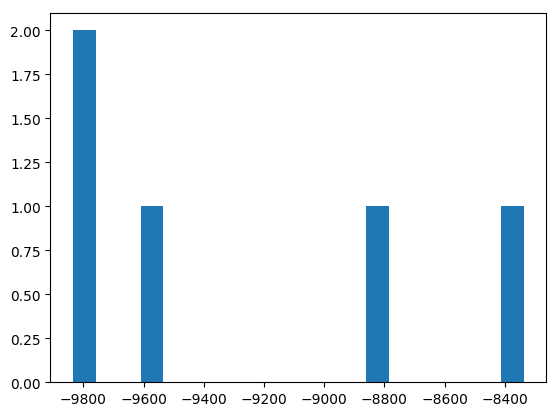

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [16]:
# Visualizing test simulation:

# test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
# HTML(test_anim.to_html5_video())


/home/user/envs/rl/lib/python3.5/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


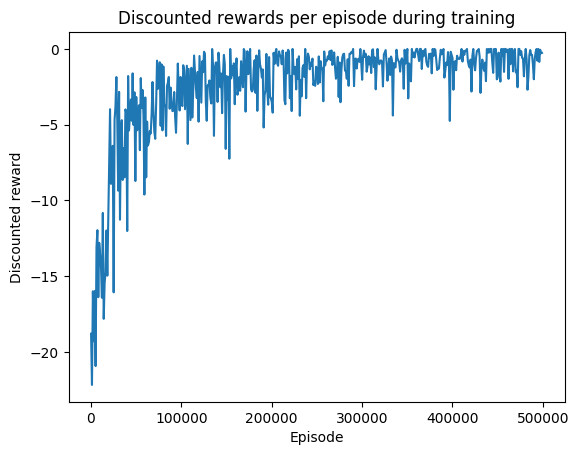

In [15]:
# Visualizing train simulation:

# episode =episodes
#simulation_id = 2
# step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,episodes,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()


### Test visualization

In [19]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks
    
    def my_indicator(x_min, x, x_max):
            if (x> x_min) & (x<=x_max):
                return 1
            else: 
                return 0
    def is_empty(x):
        if x <=0:
            return 1
        else: 
            return 0
        
    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))
        ##################### Count number of times the system is in (0,b), (b,c),(c,e),(e,1) ##########
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks[i-1].max_load
        x_maxs = np.array([b,c,e,1])*tanks[i-1].max_load

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)



    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [23]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    test_number_of_trucks_not_deliverying_list = []
    
    test_level_counts_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list, 
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        test_level_counts_list)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)

    #     if n_episodes == 1:
    first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
    print("Average 1st type Trucks sent to each shop:", first_type)
    print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

    second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
    print("Average 2nd type Trucks sent to each shop:", second_type)
    print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

    print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

    for i in range(n):
            print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )


    print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
    print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )

    
test_episodes = 1

### Deterministic consumption rates without transport/unload costs, 0.5M episodes 

Test episode: 1
Episode 1 t 0 -1333.8216445 -1333.8216445 0.0 5500
Episode 1 t 1 -540.6503856 22.7233344 563.37372 4500
Episode 1 t 2 -294.7068994 -294.7068994 0.0 5500
Episode 1 t 3 -550.7873265 -435.2234865 115.56384 0500
Episode 1 t 4 -1007.720639 -444.346919 563.37372 4500
Episode 1 t 5 -967.2909193 -382.2489793 585.04194 2500
Episode 1 t 6 -721.0033138 -157.6295938 563.37372 4500
Episode 1 t 7 -1290.4190842 -727.0453642 563.37372 4500
Episode 1 t 8 -1140.6913994 21.1379206 1161.82932 0300
Episode 1 t 9 -1589.6770722 19.9621278 1609.6392 4300
Episode 1 t 10 -30.5853366 -30.5853366 0.0 5500
Episode 1 t 11 -2465.1622378 -833.8548178 1631.30742 2300
Episode 1 t 12 -1414.1956526 -252.3663326 1161.82932 0400
Episode 1 t 13 -1592.284868 28.188442 1620.47331 1300
Episode 1 t 14 -1588.6784874 20.9607126 1609.6392 3300
Episode 1 t 15 -1013.1558201 -449.7821001 563.37372 4500
Episode 1 t 16 -1137.3531583 24.4761617 1161.82932 0300
Episode 1 t 17 -917.3037044 -332.2617644 585.04194 2500
Episo

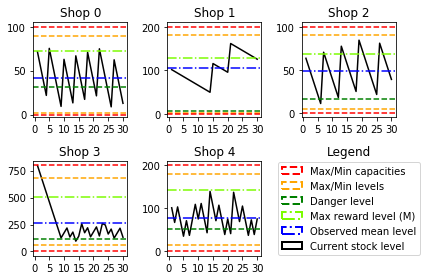

Total discounted rewards Level rewards Transport rewards
-9834.189044725119 -8595.716924731862 27315.37085999999
Average trucks sent:  41.0
Average 1st type Trucks sent to each shop: [ 7.  2.  4.  3. 10.  4.]
Average 1st type Trucks sent: 26.0
Average 2nd type Trucks sent to each shop: [ 0.  0.  0. 13.  2. 15.]
Average 2nd type Trucks sent: 15.0
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 0.  0. 11. 19.  0.]
Average level counts for shop 1: [ 0.  0.  0. 30.  0.]
Average level counts for shop 2: [ 0.  0.  1. 29.  0.]
Average level counts for shop 3: [ 0.  0.  1. 27.  2.]
Average level counts for shop 4: [ 0.  0.  7. 23.  0.]
Average total level counts: [  0.   0.  20. 128.   2.]
Percentage total level counts: [ 0.          0.         13.33333333 85.33333333  1.33333333]


In [24]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 1)


Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5
Test episode: 6
Test episode: 7
Test episode: 8
Test episode: 9
Test episode: 10
Test episode: 11
Some tank is in a forbidden level
Test episode: 12
Test episode: 13
Test episode: 14
Test episode: 15
Test episode: 16
Test episode: 17
Some tank is in a forbidden level
Test episode: 18
Test episode: 19
Test episode: 20
Test episode: 21
Test episode: 22
Some tank is in a forbidden level
Test episode: 23
Some tank is in a forbidden level
Test episode: 24
Some tank is in a forbidden level
Test episode: 25
Test episode: 26
Some tank is in a forbidden level
Test episode: 27
Test episode: 28
Test episode: 29
Test episode: 30
Test episode: 31
Test episode: 32
Test episode: 33
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 34
Test episode: 35
Some tank is in a forbidden level
Test episode: 36
Test episode: 37
Some tank is in a forbidden level
Some tank is in a forbidden level
Test e

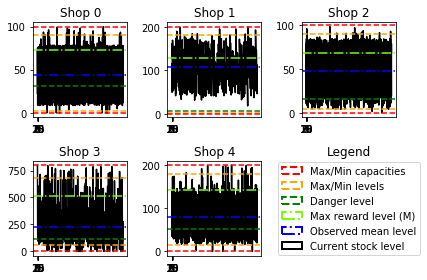

Total discounted rewards Level rewards Transport rewards
-79457.27856345916 -374889.34664697456 29229.562051200006
Average trucks sent:  42.37
Average 1st type Trucks sent to each shop: [6.75 1.02 4.39 4.78 8.3  4.76]
Average 1st type Trucks sent: 25.240000000000002
Average 2nd type Trucks sent to each shop: [ 0.    0.2   0.   13.98  2.95 12.87]
Average 2nd type Trucks sent: 17.13
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 0.07  0.    9.28 20.46  0.19]
Average level counts for shop 1: [ 0.   0.   0.  29.7  0.3]
Average level counts for shop 2: [1.000e-02 1.100e-01 1.330e+00 2.844e+01 1.100e-01]
Average level counts for shop 3: [ 0.22  0.65  1.74 27.06  0.33]
Average level counts for shop 4: [3.000e-02 2.000e-02 6.890e+00 2.294e+01 1.200e-01]
Average total level counts: [  0.33   0.78  19.24 128.6    1.05]
Percentage total level counts: [ 0.22        0.52       12.82666667 85.73333333  0.7       ]


In [22]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 100)
